<a href="https://colab.research.google.com/github/MOTURUPRAVEENBHARGAV/bert_models/blob/main/Multi_Class_Tf_Hub_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For Reference: https://www.analyticsvidhya.com/blog/2020/10/simple-text-multi-classification-task-using-keras-bert/

GitHub: https://github.com/chandrashekhar1227-ML/Git_hub_bugs_prediction_using_Keras_BERT/blob/main/git-hub-bugs-prediction-using-bert.ipynb

BERT is a model that knows to represent text. You give it some sequence as an input, it then looks left and right several times and produces a vector representation for each word as the output. At the end of 2018 researchers at Google AI Language open-sourced a new technique for Natural Language Processing (NLP) called BERT (Bidirectional Encoder Representations from Transformers). A major breakthrough that took the Deep Learning community by storm because of its incredible performance.

# How does it work?

BERT relies on a Transformer (the attention mechanism that learns contextual relationships between words in a text). A basic Transformer consists of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT’s goal is to generate a language representation model, it only needs the encoder part. The input to the encoder for BERT is a sequence of tokens, which are first converted into vectors and then processed in the neural network. But before processing can start, BERT needs the input to be massaged and decorated with some extra metadata:

- Token embeddings: A [CLS] token is added to the input word tokens at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.
- Segment embeddings: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.
- Positional embeddings: A positional embedding is added to each token to indicate its position in the sentence.

Loading the Required Packages

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
logging.basicConfig(level=logging.INFO)

We will need a BERT Tokenization Class

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

## Build a BERT Layer

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 18.2MB/s 


In [ ]:
import tensorflow_hub as hub
import tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

## Load the Data

In [ ]:
data=pd.read_csv("/content/drive/My Drive/Sentiment Analysis_Preskale/EDA FOR REVIEWS DATASET/Cleaned_reviews.csv",index_col="Unnamed: 0")
data.head()

,userName,content,score,Polarity,clean_text,common_words
0,Andrew Thomas,Update: After getting a response from the deve...,1,Negative,update getting response developer would change...,"['update', 'getting', 'response', 'developer',..."
1,Craig Haines,Used it for a fair amount of time without any ...,1,Negative,used fair amount time without problem suddenly...,"['used', 'fair', 'amount', 'time', 'without', ..."
2,steven adkins,Your app sucks now!!!!! Used to be good but no...,1,Negative,app suck used good doesnt update physically op...,"['app', 'suck', 'used', 'good', 'doesnt', 'upd..."
3,Lars Panzerbjørn,"It seems OK, but very basic. Recurring tasks n...",1,Negative,seems ok basic recurring task need work actual...,"['seems', 'ok', 'basic', 'recurring', 'task', ..."
4,Scott Prewitt,Absolutely worthless. This app runs a prohibit...,1,Negative,absolutely worthless app run prohibitively clu...,"['absolutely', 'worthless', 'app', 'run', 'pro..."


In [ ]:
data=data.loc[:,["content","Polarity","clean_text"]]
data.columns

Index(['content', 'Polarity', 'clean_text'], dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15746 entries, 0 to 15745
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   content     15746 non-null  object
 1   Polarity    15746 non-null  object
 2   clean_text  15737 non-null  object
dtypes: object(3)
memory usage: 492.1+ KB


In [ ]:
data.isnull().sum()

content       0
Polarity      0
clean_text    9
dtype: int64

In [ ]:
data.dropna(inplace=True)
data.reset_index(inplace=True,drop=True)
data.head()

,content,Polarity,clean_text
0,Update: After getting a response from the deve...,Negative,update getting response developer would change...
1,Used it for a fair amount of time without any ...,Negative,used fair amount time without problem suddenly...
2,Your app sucks now!!!!! Used to be good but no...,Negative,app suck used good doesnt update physically op...
3,"It seems OK, but very basic. Recurring tasks n...",Negative,seems ok basic recurring task need work actual...
4,Absolutely worthless. This app runs a prohibit...,Negative,absolutely worthless app run prohibitively clu...


In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data["Polarity"]=le.fit_transform(data["Polarity"])
data.head()

,content,Polarity,clean_text
0,Update: After getting a response from the deve...,0,update getting response developer would change...
1,Used it for a fair amount of time without any ...,0,used fair amount time without problem suddenly...
2,Your app sucks now!!!!! Used to be good but no...,0,app suck used good doesnt update physically op...
3,"It seems OK, but very basic. Recurring tasks n...",0,seems ok basic recurring task need work actual...
4,Absolutely worthless. This app runs a prohibit...,0,absolutely worthless app run prohibitively clu...


In [ ]:
data.Polarity.value_counts().rename({2:'Positive',0:'Negative',1:'Neutral'})

Positive    5674
Neutral     5037
Negative    5026
Name: Polarity, dtype: int64

## Encoding the raw text

[Tokenization](https://huggingface.co/transformers/main_classes/tokenizer.html) is a process to take raw texts and split into tokens, which are numeric data to represent words.

Official [BERT](https://huggingface.co/transformers/main_classes/tokenizer.html) language models are pre-trained with WordPiece vocabulary and use, not just token embeddings, but also segment embeddings distinguish between sequences, which are in pairs, e.g. question answering examples. Position embeddings are needed in order to inject positional awareness into the BERT model as the attention mechanism does not consider positions in context evaluation.

The important limitation of BERT to be aware of is that the maximum length of the sequence for BERT is 512 tokens. For shorter sequence input than the maximum allowed input size, we would need to add pad tokens [PAD]. On the other hand, if the sequence is longer, we need to cut the sequence. This BERT limitation on the maximum length of the sequence is something that you need to be aware of for longer text segments.

Very important are also the so-called special tokens, e.g. [CLS] token and [SEP] tokens. The [CLS] token will be inserted at the beginning of the sequence, the [SEP] token is at the end. If we deal with sequence pairs we will add additional [SEP] token at the end of the last.

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

# Build the Model

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(3, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

ReLu: The Rectified Linear Unit is the most commonly used activation function in deep learning models. The function returns 0 if it receives any negative input, but for any positive value, it returns that value back.

Softmax: The function is great for classification problems, especially if we’re dealing with multi-class classification problems, as it will report back the “confidence score” for each class. Since we’re dealing with probabilities here, the scores returned by the softmax function will add up to 1.


We check only the first 150 characters of each review.

You can also increase this length, but the running time will increase too

number of categories=3(bug,feature,question)

In [ ]:
data["Polarity"]=data.Polarity.astype(str)

In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(data, test_size=0.2, random_state=42)
train["clean_text"] = (train['clean_text'].map(str)).apply(lambda row: row.strip())
test["clean_text"] = (test['clean_text'].map(str)).apply(lambda row: row.strip())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
from tensorflow.keras.utils import to_categorical
max_len = 150
train_input = bert_encode(train.clean_text.values, tokenizer, max_len=max_len)
test_input = bert_encode(test.clean_text.values, tokenizer, max_len=max_len)
train_labels = to_categorical(train.Polarity.values, num_classes=3)


In [ ]:
test_labels = to_categorical(test.Polarity.values, num_classes=3)


In [ ]:
model= build_model(bert_layer, max_len= max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

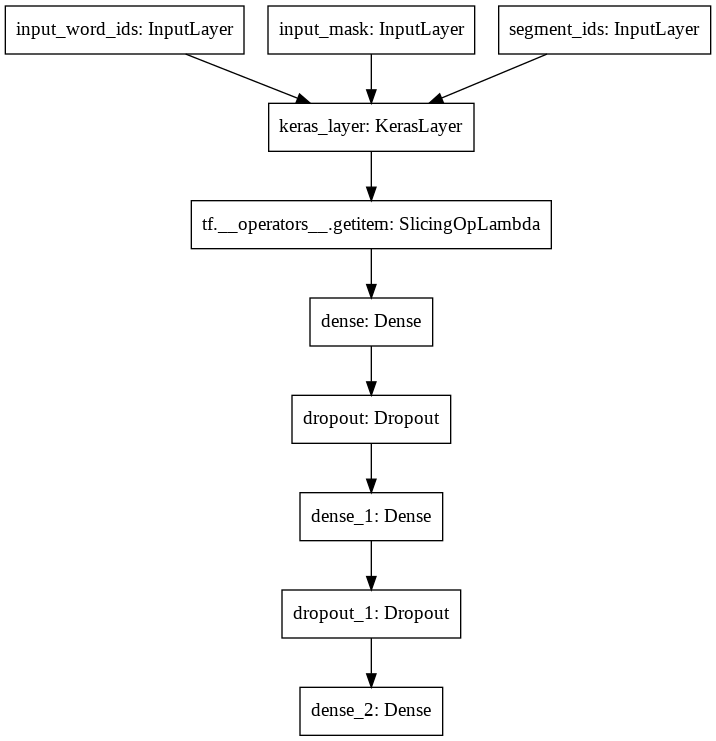

In [ ]:
tf.keras.utils.plot_model(model)

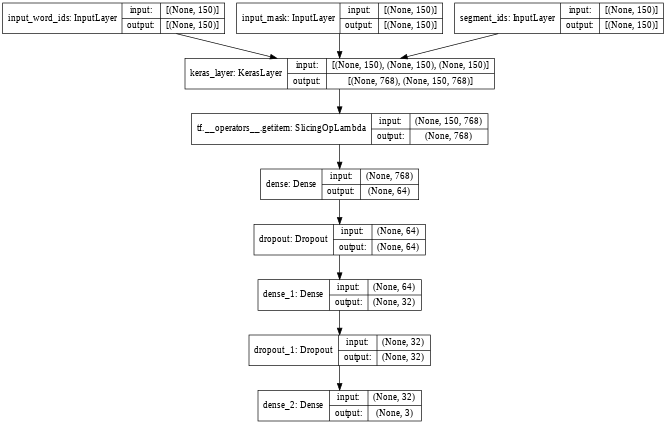

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Sentiment Analysis_Preskale/model.h5', monitor='val_accuracy', save_best_only=True, verbose=2)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=2)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=35,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/35
315/315 [==============================] - 323s 1s/step - loss: 0.0912 - accuracy: 0.9687 - val_loss: 1.1785 - val_accuracy: 0.7979

Epoch 00001: val_accuracy improved from -inf to 0.79786, saving model to /content/drive/MyDrive/Sentiment Analysis_Preskale/model.h5
Epoch 2/35
315/315 [==============================] - 323s 1s/step - loss: 0.0853 - accuracy: 0.9697 - val_loss: 1.2301 - val_accuracy: 0.7947

Epoch 00002: val_accuracy did not improve from 0.79786
Epoch 3/35
315/315 [==============================] - 323s 1s/step - loss: 0.0858 - accuracy: 0.9701 - val_loss: 1.2564 - val_accuracy: 0.8018

Epoch 00003: val_accuracy improved from 0.79786 to 0.80183, saving model to /content/drive/MyDrive/Sentiment Analysis_Preskale/model.h5
Epoch 4/35
315/315 [==============================] - 323s 1s/step - loss: 0.0737 - accuracy: 0.9736 - val_loss: 1.3082 - val_accuracy: 0.7927

Epoch 00004: val_accuracy did not improve from 0.80183
Epoch 5/35
315/315 [=========================

In [ ]:
%%time
score = model.evaluate(test_input,test_labels, batch_size=32)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

99/99 [==============================] - 33s 333ms/step - loss: 1.3394 - accuracy: 0.7865

ACCURACY: 0.7865311503410339
LOSS: 1.339408040046692
CPU times: user 2.59 s, sys: 1.76 s, total: 4.35 s
Wall time: 33.1 s


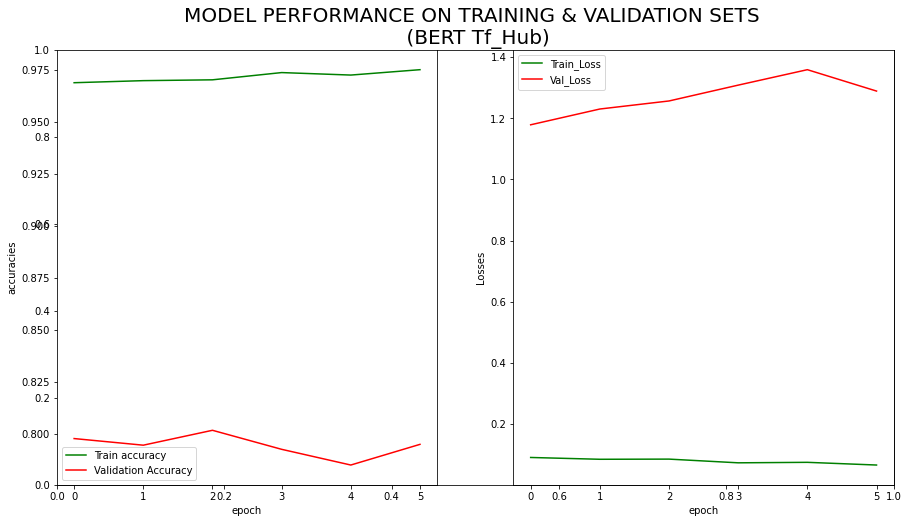

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
 
fig=plt.figure(figsize=(15,8))
plt.title("MODEL PERFORMANCE ON TRAINING & VALIDATION SETS \n (BERT Tf_Hub)",fontsize= 20)
fig1=fig.add_subplot(121)
plt.plot(train_history.history['accuracy'],color='Green')
plt.plot(train_history.history["val_accuracy"],color='red')
# plt.ylim(0.90, 1.05)
plt.xlabel("epoch")
plt.ylabel("accuracies")
plt.legend(['Train accuracy','Validation Accuracy'])

fig2=fig.add_subplot(122)
plt.plot(train_history.history["loss"],color='g')
plt.plot(train_history.history["val_loss"],color='r')
# plt.ylim(0.0, 1)
plt.xlabel("epoch")
plt.ylabel("Losses")

plt.legend(['Train_Loss','Val_Loss'])

plt.show()
# files.download( "Model Performance.jpg" ) 

In [ ]:
model.save("/content/drive/MyDrive/Sentiment Analysis_Preskale/BERT Multi_Class_model.h5") # -- MODEL.h5  WORKS BECAUSE IT IS A FUNCTIONAL MODEL, SEQUENCE MODEL NOT THE SUBCLASSED MODEL. 

In [ ]:
model.load_weights("/content/drive/MyDrive/Sentiment Analysis_Preskale/model.h5")

In [ ]:
test_pred = model.predict(test_input)
test_pred

array([[9.99862671e-01, 1.00699755e-04, 3.65515334e-05],
       [1.45830843e-03, 9.98356640e-01, 1.85063604e-04],
       [7.61307962e-03, 7.56099820e-01, 2.36287087e-01],
       ...,
       [7.57685120e-05, 9.99868870e-01, 5.52859165e-05],
       [1.48851480e-02, 2.87321419e-01, 6.97793484e-01],
       [9.99749720e-01, 2.17203968e-04, 3.30958901e-05]], dtype=float32)

In [ ]:
y_pred= np.argmax(test_pred,axis=1)
y_pred

array([0, 1, 1, ..., 1, 2, 0])

In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
print(test["Polarity"].shape)
y_pred.shape

(3148,)


(3148,)

In [ ]:
y_test = list(test["Polarity"].values.astype(int))
y_pred  = list(y_pred)

In [ ]:
print(y_test)

[0, 0, 2, 2, 0, 1, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 1, 0, 0, 2, 0, 2, 2, 0, 2, 1, 0, 0, 1, 0, 1, 0, 2, 0, 2, 0, 0, 1, 0, 2, 1, 2, 1, 2, 2, 1, 0, 1, 2, 1, 1, 2, 0, 1, 1, 0, 2, 0, 0, 1, 2, 2, 0, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 1, 2, 1, 2, 0, 0, 2, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 2, 1, 0, 2, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 2, 2, 0, 1, 0, 1, 2, 2, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 2, 0, 1, 2, 0, 1, 0, 2, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 2, 2, 0, 1, 0, 1, 1, 2, 2, 1, 1, 0, 0, 0, 1, 2, 2, 0, 1, 0, 0, 2, 1, 2, 0, 2, 0, 2, 2, 0, 0, 0, 1, 2, 2, 2, 1, 2, 0, 0, 2, 1, 2, 2, 1, 0, 0, 0, 1, 0, 2, 1, 2, 1, 1, 1, 0, 0, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 1, 2, 1, 0, 2, 1, 0, 1, 2, 1, 2, 2, 2, 0, 1, 1, 1, 0, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 1, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 0, 0, 2, 2, 1, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 

In [ ]:
print(y_pred)

[0, 1, 1, 2, 0, 1, 1, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 2, 1, 0, 0, 2, 1, 1, 0, 2, 0, 2, 0, 0, 1, 0, 2, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 1, 2, 0, 1, 2, 0, 2, 0, 0, 1, 2, 2, 0, 2, 1, 2, 1, 2, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 2, 0, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 0, 2, 0, 1, 2, 2, 1, 1, 2, 2, 1, 1, 0, 2, 2, 2, 1, 2, 1, 0, 2, 2, 1, 0, 2, 2, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 2, 0, 1, 2, 0, 2, 0, 2, 1, 2, 1, 2, 2, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 2, 2, 0, 2, 0, 1, 1, 2, 2, 1, 1, 1, 0, 0, 1, 2, 2, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 0, 1, 0, 2, 1, 0, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 2, 2, 1, 0, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 2, 1, 0, 2, 0, 1, 2, 0, 1, 2, 0, 0, 1, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 0, 0, 2, 1, 1, 2, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 

In [ ]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[ 796,  149,   83],
       [ 115,  684,  162],
       [  37,   97, 1025]])

In [ ]:
#plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Multi_Class_TF.Hub BERT Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="right",
                 color="White" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    plt.show()

Confusion matrix, without normalization


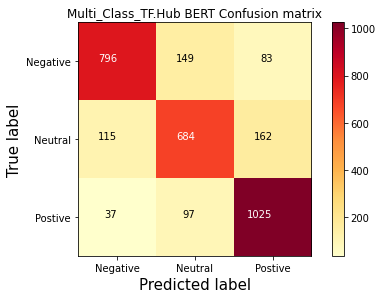

In [ ]:
import itertools
plot_confusion_matrix(cm,["Negative","Neutral","Postive"])
plt.show()

In [ ]:

from sklearn.metrics import accuracy_score
print("\t\tMulti Class TF_hub_BERT\n\n")
print("Accuracy of BERT is:",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred,target_names=['Negative', 'Neutral','Positive']))


		Multi Class TF_hub_BERT


Accuracy of BERT is: 0.7957433290978398
              precision    recall  f1-score   support

    Negative       0.84      0.77      0.81      1028
     Neutral       0.74      0.71      0.72       961
    Positive       0.81      0.88      0.84      1159

    accuracy                           0.80      3148
   macro avg       0.79      0.79      0.79      3148
weighted avg       0.80      0.80      0.79      3148



In [ ]:
test["predicted"]=np.array(y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,content,Polarity,clean_text,predicted
10871,Impossible to use.,0,impossible use,0
1210,Wow... A To Do list app without the option to ...,0,wow list app without option make task recurrin...,1
14289,Very good... Just one point. When listing comi...,2,good one point listing coming task would good ...,1
10434,Made outlook play nicely by just importing my ...,2,made outlook play nicely importing outlook cal...,2
12458,complicated,0,complicated,0
...,...,...,...,...
10887,At the features are premium 😐,0,feature premium 😐,0
3029,Back button doesnt work,1,back button doesnt work,1
6661,"So far it's not flexible enough for me. Also, ...",1,far flexible enough also need option remove ge...,1
2075,Very nice app with a lot of integrations which...,2,nice app lot integration make comfortable use ...,2


In [ ]:
test["Polarity"]= test["Polarity"].apply(lambda x: "Negative" if x== 0 else ('Neutral' if x== 1 else "Positive" ) )
test["predicted"]= test["predicted"].apply(lambda x: "Negative" if x== 0 else ('Neutral' if x== 1 else "Positive" ) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# cond=[test.predicted==0,test.predicted==1,test.predicted==2]
# cond1=[test.==0,test.predicted==1,test.predicted==2]
# choice=["Negative","Neutral","Positive"]
# test.Polarity=np.select(cond,choice)
# test.predicted= np.select(cond,choice)
# test.Polarity.head()

In [ ]:
test.head(15)

,content,Polarity,clean_text,predicted
10871,Impossible to use.,Negative,impossible use,Negative
1210,Wow... A To Do list app without the option to ...,Negative,wow list app without option make task recurrin...,Neutral
14289,Very good... Just one point. When listing comi...,Positive,good one point listing coming task would good ...,Neutral
10434,Made outlook play nicely by just importing my ...,Positive,made outlook play nicely importing outlook cal...,Positive
12458,complicated,Negative,complicated,Negative
4367,This app is great and it already helping me st...,Neutral,app great already helping stay track thing sur...,Neutral
7581,I would love to do a one/life time purchase fo...,Positive,would love onelife time purchase app bad hate ...,Neutral
13233,It is really good and dies not have any ads al...,Positive,really good dy ad also really good tidying,Positive
5344,the app again crashed after updating... its no...,Neutral,app crashed updating even responding,Negative
8323,Awesome. Simple and easy to use.,Positive,awesome simple easy use,Positive
